Let's create our windowed sinc table.

In [1]:
import numpy as np
from scipy.special import sinc
from scipy.signal.windows import kaiser
import matplotlib.pyplot as plt

def build_sinc_table(num_zeros, samples_per_crossing):

    SINC_SIZE_ = num_zeros * samples_per_crossing
    KAISER_BETA = 10

    x = np.linspace(-num_zeros, num_zeros, SINC_SIZE_ * 2 + 1)
    y = sinc(x)

    window = kaiser(len(y), KAISER_BETA)

    y = np.multiply(y, window)

    h = y[SINC_SIZE_:]

    h_diff = np.subtract(h[1:], h[:-1])
    h_diff = np.append(h_diff, 0)

    return h, h_diff

In [2]:
from math import ceil

def sinc_resample(x, ratio, h, h_diff, num_zeroes, samples_per_crossing):
    time_step = 1 / ratio
    filter_scale = min(1, ratio)
    filter_step = samples_per_crossing * filter_scale

    output = np.ndarray(shape=ceil(len(x) * ratio))
    out_idx = 0
    t = 0
    while t < len(x):

        acc = 0

        integer_part = int(t)
        fractional_part = t - integer_part

        # Compute left wing
        filter_x = filter_step * fractional_part
        filter_offset = int(filter_x)
        frac = filter_x - filter_offset

        max_h_left = min(integer_part, num_zeroes-1)
        for i in range(-max_h_left, 1):
            filter_idx = int(filter_offset + filter_step * abs(i))
            weight = h[filter_idx] + frac * h_diff[filter_idx]
            acc += x[integer_part + i] * weight

        # compute right wing
        fractional_part = 1 - fractional_part
        filter_x = filter_step * fractional_part
        filter_offset = int(filter_x)
        frac = filter_x - filter_offset

        max_h_right = min(len(x) - integer_part - 1, num_zeroes-1)
        for i in range(0, max_h_right):
            filter_idx = int(filter_offset + filter_step * i)
            weight = h[filter_idx] + frac * h_diff[filter_idx]
            acc += x[integer_part + 1 + i] * weight

        if out_idx < len(output):
            output[out_idx] = acc
            out_idx += 1
        t += time_step

    return output


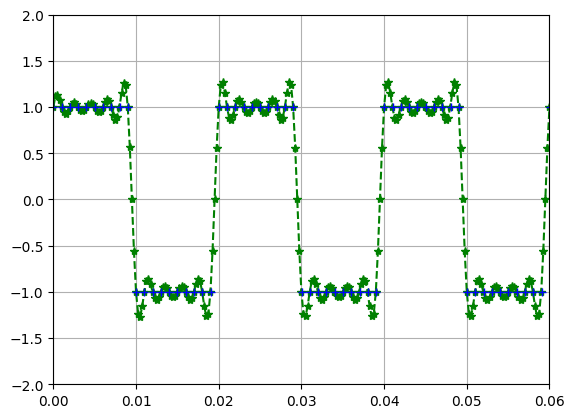

In [3]:
from scipy import signal

# Number of zeros crossing
NZ = 13

# Number of samples per zero crossing.
# Higher sample count means better precision for our interpolation at the cost of more memory usage.
SAMPLES_PER_CROSSING = 512
h, h_diff = build_sinc_table(NZ, SAMPLES_PER_CROSSING)

ORIGINAL_FS = 1000
SIGNAL_FREQUENCY = 50
TARGET_FS = ORIGINAL_FS * 4

time = np.linspace(0, 1, ORIGINAL_FS)
in_sine = signal.square(2 * np.pi * time * SIGNAL_FREQUENCY)

output = sinc_resample(in_sine, TARGET_FS / ORIGINAL_FS, h, h_diff, NZ, SAMPLES_PER_CROSSING)
out_time = np.linspace(0, 1, TARGET_FS)
plt.plot(out_time, output, 'g*--')
plt.plot(time, in_sine, 'b+')
plt.xlim(0.0, 0.06)
plt.ylim(-2, 2)
plt.grid()
plt.show()

In [4]:

ORIGINAL_FS = 96000
CHIRP_LENGTH_SECONDS = 8
END_CHIRP_FREQUENCY = 44000

time = np.linspace(0, CHIRP_LENGTH_SECONDS, ORIGINAL_FS*CHIRP_LENGTH_SECONDS)
in_chirp = signal.chirp(time, 0, CHIRP_LENGTH_SECONDS, END_CHIRP_FREQUENCY, 'quadratic')


Let's use a spectrogram to see what our chirp looks like:

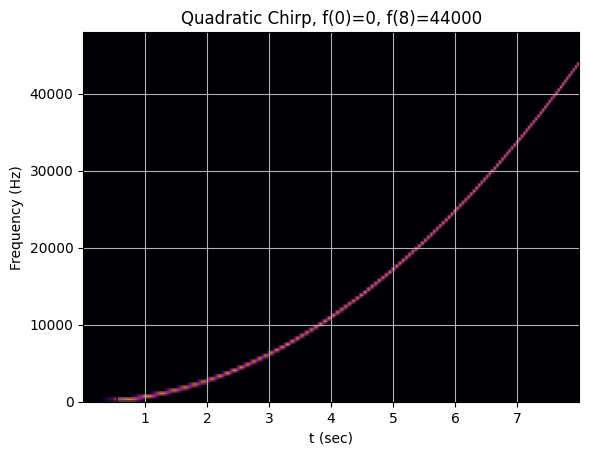

In [5]:
from scipy.signal import spectrogram

def plot_spectrogram(title, w, fs, ax = None):
    ff, tt, Sxx = spectrogram(w, fs=fs)
    if ax is None:
        fig, ax = plt.subplots()
    ax.pcolormesh(tt, ff, Sxx, cmap='magma', shading='gouraud')
    ax.set_title(title)
    ax.set_xlabel('t (sec)')
    ax.set_ylabel('Frequency (Hz)')
    ax.grid(True)

plot_spectrogram(f'Quadratic Chirp, f(0)=0, f({CHIRP_LENGTH_SECONDS})={END_CHIRP_FREQUENCY}', in_chirp, ORIGINAL_FS)

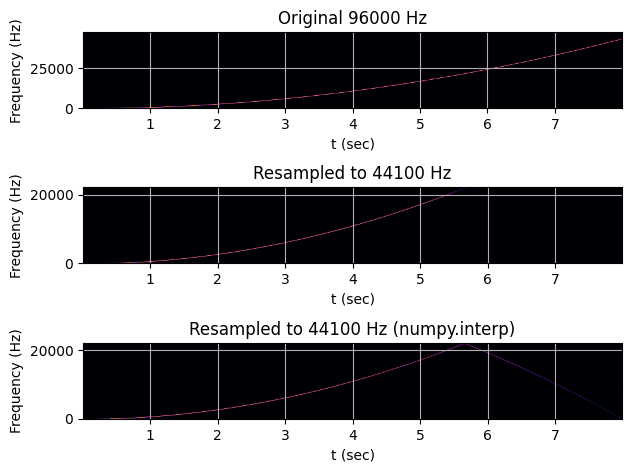

In [10]:
TARGET_FS = 44100
RESAMPLING_RATIO = TARGET_FS / ORIGINAL_FS

NZ = 13
SAMPLES_PER_CROSSING = 64
h, h_diff = build_sinc_table(NZ, SAMPLES_PER_CROSSING)

output = sinc_resample(
    in_chirp,
    RESAMPLING_RATIO,
    h,
    h_diff,
    NZ,
    SAMPLES_PER_CROSSING)

out_time = np.linspace(0, CHIRP_LENGTH_SECONDS, TARGET_FS*CHIRP_LENGTH_SECONDS)
out_linear = np.interp(out_time, time, in_chirp)

fig, ax = plt.subplots(3, 1)
plot_spectrogram(f"Original {ORIGINAL_FS} Hz", in_chirp, ORIGINAL_FS, ax[0])
plot_spectrogram(f"Resampled to {TARGET_FS} Hz", output, TARGET_FS, ax[1])
plot_spectrogram(f"Resampled to {TARGET_FS} Hz (numpy.interp)", out_linear, TARGET_FS, ax[2])
fig.tight_layout(pad=1.0)
plt.show()